In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cmath
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d

from Functions import *

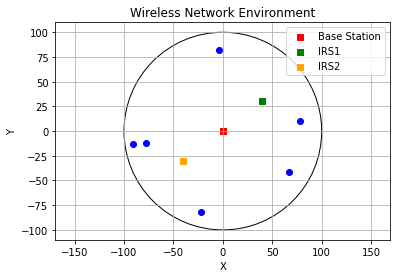

In [287]:
#============== System parameters

Nt = 1                 # Number of transmit antennas at the base station # h_dk have to chance for multiple antennas
nIRSrow = 3             # Number of rows in the IRS
nIRScol = 3             # Number of columns in the IRS

Ns = nIRSrow*nIRScol    # Total Number of reflecting elements in the IRS
No_of_Users = 6         # Number of users in the system

f = 2.4e9               # Frequency in Hz for calculation dstance bewtween IRS elements
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda

BW = 50e6               # Bandwidth
NF = 10                 # Noise Figure
noise = -174+10*np.log10(BW) + NF

GRID_RADIUS = 100
BASE_STATION_POSITION = (0, 0)
TRANSMIT_POWER_WATTS = 4 #in watts

FADING_STD_MEAN = 0
FADING_STD_DEV = 3
m = 1
omega = np.sqrt(0.5)

# Power Consumptions
pc_of_1bit_ps_dBm  = 5 #in dBm
pc_of_1bit_ps = 10**(pc_of_1bit_ps_dBm/10)/1000 #in watts
pc_of_2bit_ps_dBm  = 10 #in dBm
pc_of_2bit_ps = 10**(pc_of_2bit_ps_dBm/10)/1000 #in watts
pc_of_3bit_ps_dBm  = 15 #in dBm
pc_of_3bit_ps = 10**(pc_of_3bit_ps_dBm/10)/1000 #in watts
pc_of_BS_dBw = 20 #in dBw
pc_of_BS = 10**(pc_of_BS_dBw/10) #in watts 
pc_of_user_dBm = 10 #in dBm
pc_of_user = 10**(pc_of_user_dBm/10)/1000 #in watts

# Path Loss Exponents
PATH_LOSS_EXPONENT = 2.2 #path loss exponent (indirect) BS-IRS
BETA = 2.8 #path loss exponent (indirect) IRS-User
ZETA = 3.8 #path loss exponent (direct)

IRS_1_POSITION = (40,30)
IRS_2_POSITION = (-40,-30)

# Generate user positions fixed
# user_positions = [[40,-30], [-40,30]]
# user_positions = np.array(user_positions)
# print(user_positions)
 
# Generate user positions general
user_positions = generate_user_positions_2D(No_of_Users, GRID_RADIUS)

loc_U = np.array(user_positions)

# print('User positions:')
# print(loc_U)

# Generate antennas position
AP_position = generate_station_positions_2D(BASE_STATION_POSITION)
xt, yt = AP_position[0]

loc_T = generate_transmit_antenna_coordinates_2D(Nt, xt, yt, halfLambda, quarterLambda)
# print('\n''Transmit antenna position:')
# print(loc_T)

# Generate IRS position
irs_1_position = generate_IRS_2D(IRS_1_POSITION)
xs1, ys1 = irs_1_position[0]
irs_2_position = generate_IRS_2D(IRS_2_POSITION)
xs2, ys2 = irs_2_position[0]

loc_S1 = generate_irs_coordinates_2D(xs1, ys1, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S2 = generate_irs_coordinates_2D(xs2, ys2, nIRSrow, nIRScol, halfLambda, quarterLambda)

# print('\n''IRS 1 position:')
# print(loc_S1)
# print('\n''IRS 2 position:')
# print(loc_S2)

dTU = compute_distances_2(loc_T, loc_U)
dS1U = compute_distances_2(loc_S1, loc_U)
dS2U = compute_distances_2(loc_S2, loc_U)
dTS1 = compute_distances_2(loc_T, loc_S1)
dTS2 = compute_distances_2(loc_T, loc_S2)

dS1S2 = np.sqrt(np.square(xs2-xs1) + np.square(ys2-ys1))

# print('\n''Distance Irs and users:')
# print(dS1U)

# Plot the grid, base station, and user positions
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), GRID_RADIUS, edgecolor='black', facecolor='none')
ax.add_patch(circle)
plt.scatter(0, 0, color='red', marker='s', label='Base Station')
plt.scatter(IRS_1_POSITION[0], IRS_1_POSITION[1], color='green', marker='s', label='IRS1')
plt.scatter(IRS_2_POSITION[0], IRS_2_POSITION[1], color='orange', marker='s', label='IRS2')
plt.scatter(user_positions[:, 0], user_positions[:, 1], color='blue', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Wireless Network Environment')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [291]:
# User association to IRS based on distance
IRS1_Associated_Users = [[0,0]]
IRS2_Associated_Users = [[0,0]]

IRS1_Associated_Users = np.array(IRS1_Associated_Users)
IRS2_Associated_Users = np.array(IRS2_Associated_Users)

for i in range(user_positions.shape[0]):
    User_i_2_IRS1 = np.sqrt(np.square(xs1-user_positions[i,0]) + np.square(ys1-user_positions[i,1]))
    User_i_2_IRS2 = np.sqrt(np.square(xs2-user_positions[i,0]) + np.square(ys2-user_positions[i,1]))

    arr = user_positions[i]

    if User_i_2_IRS1 < User_i_2_IRS2:
        IRS1_Associated_Users = np.concatenate((arr[np.newaxis, :], IRS1_Associated_Users), axis=0)
    else:
        IRS2_Associated_Users = np.concatenate((arr[np.newaxis, :], IRS2_Associated_Users), axis=0)

IRS1_Associated_Users = np.delete(IRS1_Associated_Users, -1, axis=0)
IRS2_Associated_Users = np.delete(IRS2_Associated_Users, -1, axis=0)

# print('IRS1 Associated Users: \n', IRS1_Associated_Users)
# print('IRS2 Associated Users: \n', IRS2_Associated_Users)

dTU_S1 = compute_distances_2(loc_T, IRS1_Associated_Users)
dTU_S2 = compute_distances_2(loc_T, IRS2_Associated_Users)
dS1U_S1 = compute_distances_2(loc_S1, IRS1_Associated_Users)
dS2U_S2 = compute_distances_2(loc_S2, IRS2_Associated_Users)

print('Distance between T and U for IRS1: \n', dTU_S1)
print('Distance between T and U for IRS2: \n', dTU_S2)
print('Distance between S1 and U for IRS1: \n', dS1U_S1)
print('Distance between S2 and U for IRS2: \n', dS2U_S2)


Distance between T and U for IRS1: 
 [[82.02497273 78.78296924 78.54119137]]
Distance between T and U for IRS2: 
 [[78.82307176 85.06246077 91.62539212]]
Distance between S1 and U for IRS1: 
 [[67.81618723 42.81411492 75.93564409]
 [67.85631356 42.75844229 75.91341056]
 [67.89647371 42.70278856 75.89122199]
 [67.768267   42.842537   75.99405044]
 [67.80842169 42.78690135 75.971834  ]
 [67.84861018 42.73128468 75.94966249]
 [67.72037055 42.87103135 76.05246329]
 [67.76055361 42.81543273 76.03026392]
 [67.80077048 42.75985317 76.00810946]]
Distance between S2 and U for IRS2: 
 [[72.6871711  59.73237404]
 [72.63432749 59.70805296]
 [72.58149923 59.68378742]
 [72.72055186 59.789941  ]
 [72.66773253 59.76564335]
 [72.61492857 59.7414012 ]
 [72.753971   59.84751787]
 [72.70117594 59.8232436 ]
 [72.64839629 59.7990248 ]]


# Ideal Model all users are served by both IRS (Discrete Phase Shift)

Average_Sum_Rate_per_user:  
 [[0.85177807 1.12564464 1.31014348 1.38248698 1.49458862 1.56108652
  1.59648556 1.66929496 1.69611754 1.71610336]
 [0.87983473 1.19199536 1.34855773 1.47012792 1.5496247  1.61873563
  1.66775486 1.71624447 1.7577206  1.80807359]
 [0.88497608 1.20553285 1.3615821  1.46792616 1.56456369 1.62308935
  1.68121233 1.71862402 1.78450447 1.81448583]]


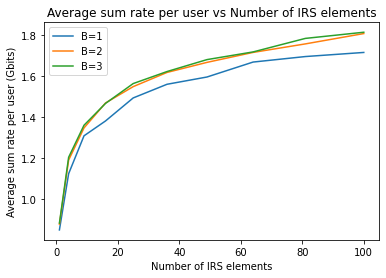

In [300]:
RATE_THRESHOLD = 1.5e9
irs_rows = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Quantization_bit = [1, 2, 3]

Average_Sum_Rate_per_user = np.zeros((3, 10), dtype=float)

# Defining the quantized theta set
for B in Quantization_bit:
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    #print('Quantized_theta_set: ',"\n", (quantized_theta_set))

    for no_irs_ele in irs_rows:

        nIRSrow = no_irs_ele    # Number of rows in the IRS
        nIRScol = no_irs_ele    # Number of columns in the IRS
        Ns = nIRSrow*nIRScol    # Total Number of reflecting elements in the IRS

        Average_rates = np.zeros((1, No_of_Users), dtype=float)
        Avera_Outage_Probability = 0.0

        NUM_SIMULATIONS = 100
        # Perform simulations
        for i in range(NUM_SIMULATIONS):

            ############################# Channels Generation ####################################
            DirectLink = np.zeros((Nt, No_of_Users), dtype=complex)
            IRS1UserLink = np.zeros((Ns, No_of_Users), dtype=complex)
            IRS2UserLink = np.zeros((Ns, No_of_Users), dtype=complex)
            BSIRS1Link = np.zeros((Nt, Ns), dtype=complex)
            BSIRS2Link = np.zeros((Nt, Ns), dtype=complex)
            
            # Generate the Rayleigh Channel (Direct_Link) from Each Base Station antenna to the each User (h_dk)
            for antenna in range(Nt):
                for user in range(user_positions.shape[0]):
                    x = generate_rayleigh_fading_channel(1, FADING_STD_MEAN, FADING_STD_DEV)
                    DirectLink[antenna, user] = x[0]
            
            DirectLink = np.array(DirectLink)

            # Generate the Nakagami Channel from each IRS1 element to each user(h_rk)
            for element in range(Ns):
                for user in range(user_positions.shape[0]):
                    y1 = (generate_nakagami_samples(m, omega, 1))
                    IRS1UserLink[element, user] = y1[0]

            IRS1UserLink = np.array(IRS1UserLink)

            # Generate the Nakagami Channel from each IRS2 element to each user(h_rk)
            for element in range(Ns):
                for user in range(user_positions.shape[0]):
                    y2 = (generate_nakagami_samples(m, omega, 1))
                    IRS2UserLink[element, user] = y2[0]

            IRS2UserLink = np.array(IRS2UserLink)

            # Generate the Nakagami Channel from each antenna to each user(h_rk)
            for antnn in range(Nt):
                for element in range(Ns):
                    z1 = (generate_nakagami_samples(m, omega, 1))
                    BSIRS1Link[antnn, element] = z1[0]

            BSIRS1Link = np.array(BSIRS1Link)

            # Generate the Nakagami Channel from each IRS1 element to each user(h_rk)
            for antnn in range(Nt):
                for element in range(Ns):
                    z2 = (generate_nakagami_samples(m, omega, 1))
                    BSIRS2Link[antnn, element] = z2[0]

            BSIRS2Link = np.array(BSIRS2Link)

            
            # print('Direct Link: \n', DirectLink)
            # print('IRS1 User Link: \n', IRS1UserLink)
            # print('IRS2 User Link: \n', IRS2UserLink)
            # print('BS IRS1 Link: \n', BSIRS1Link)
            # print('BS IRS2 Link: \n', BSIRS2Link)


            ############################# Theta Matrix Calculation ####################################
            IRS1Theta_Matrix = np.zeros((Nt, Ns, No_of_Users), dtype=complex)
            IRS2Theta_Matrix = np.zeros((Nt, Ns, No_of_Users), dtype=complex)

            for antenna in range(Nt):
                for element in range(Ns):
                    for user in range(user_positions.shape[0]):
                        # theta_n1 =  np.angle(DirectLink[antenna,user]) - (np.angle(BSIRS1Link[antenna,element]) + np.angle(IRS1UserLink[element,user]))
                        # theta_n2 =  np.angle(DirectLink[antenna,user]) - (np.angle(BSIRS2Link[antenna,element]) + np.angle(IRS2UserLink[element,user]))
                        theta_n1 = - np.angle(BSIRS1Link[antenna,element]) - np.angle(IRS1UserLink[element,user])
                        theta_n2 = - np.angle(BSIRS2Link[antenna,element]) - np.angle(IRS2UserLink[element,user])

                        # Adjust theta_n to lie within the range (-π, π)
                        theta_n1 = (theta_n1 + np.pi) % (2 * np.pi) - np.pi
                        theta_n2 = (theta_n2 + np.pi) % (2 * np.pi) - np.pi
                        
                        # Find the nearest quantized theta value
                        nearest_quantized_theta1 = quantized_theta_set[np.argmin(np.abs(theta_n1 - quantized_theta_set))]
                        nearest_quantized_theta2 = quantized_theta_set[np.argmin(np.abs(theta_n2 - quantized_theta_set))]

                        IRS1Theta_Matrix[antenna,element,user] = nearest_quantized_theta1
                        IRS2Theta_Matrix[antenna,element,user] = nearest_quantized_theta2
                    
            IRS1Theta_Matrix = (1 * np.exp(1j * IRS1Theta_Matrix))
            IRS2Theta_Matrix = (1 * np.exp(1j * IRS2Theta_Matrix))

            # print('IRS1Theta_Matrix \n', IRS1Theta_Matrix)
            # print('IRS1Theta_Matrix shape \n', IRS2Theta_Matrix.shape)


            ############################# Result Matrix Calculation ####################################
            IRS1Result_Matrix = np.zeros((Nt, No_of_Users), dtype=complex)
            IRS2Result_Matrix = np.zeros((Nt, No_of_Users), dtype=complex)

            for antenna in range(Nt):
                for user in range(user_positions.shape[0]):
                    #extrcating the theta array
                    theta_row1 = IRS1Theta_Matrix[antenna,:,user]
                    theta_row1 = np.reshape(theta_row1,(1,no_irs_ele**2))
                    theta_row1 = np.array(theta_row1)

                    # print('theta_row1\n',theta_row1)
                    # print('theta_row1 shape\n',theta_row1.shape)

                    theta_row2 = IRS2Theta_Matrix[antenna,:,user]
                    theta_row2 = np.reshape(theta_row2,(1,no_irs_ele**2))
                    theta_row2 = np.array(theta_row2)
                    
                    #converting the theta array into diagonal matrix
                    diag_thetarow1 = np.diag(theta_row1[0])
                    # print('diag_thetarow1\n',diag_thetarow1)
                    # print('diag_thetarow1 shape\n',diag_thetarow1.shape)
                    diag_thetarow2 = np.diag(theta_row2[0])

                    #extrcating the BSIRS array
                    BSIRS1Link_row = BSIRS1Link[antenna,:]
                    BSIRS1Link_row = np.reshape(BSIRS1Link_row,(1,no_irs_ele**2))
                    BSIRS1Link_row = np.array(BSIRS1Link_row)
                    # print('BS to IRS\n',BSIRS1Link_row)
                    # print('BS to IRS shape\n',BSIRS1Link_row.shape)
                    BSIRS2Link_row = BSIRS2Link[antenna,:]
                    BSIRS2Link_row = np.reshape(BSIRS2Link_row,(1,no_irs_ele**2))
                    BSIRS2Link_row = np.array(BSIRS2Link_row)

                    #exracting the IRS(1,2)UserLink array
                    IRS1UserLink_row = IRS1UserLink[:,user]
                    IRS1UserLink_row = np.reshape(IRS1UserLink_row,(no_irs_ele**2,1))
                    IRS1UserLink_row = np.array(IRS1UserLink_row)
                    # print('IRS to User\n',IRS1UserLink_row)
                    # print('IRS to User shape\n',IRS1UserLink_row.shape)
                    IRS2UserLink_row = IRS2UserLink[:,user]
                    IRS2UserLink_row = np.reshape(IRS2UserLink_row,(no_irs_ele**2,1))
                    IRS2UserLink_row = np.array(IRS2UserLink_row)

                    # Calculating the result matrix
                    inter1 = np.matmul(BSIRS1Link_row, diag_thetarow1)
                    final1 = np.matmul(inter1, IRS1UserLink_row)
                    IRS1Result_Matrix[antenna,user] = final1[0,0]

                    inter2 = np.matmul(BSIRS2Link_row, diag_thetarow2)
                    final2 = np.matmul(inter2, IRS2UserLink_row)
                    # print('final2\n',final2)
                    # print('final2 shape\n',final2.shape)
                    IRS2Result_Matrix[antenna,user] = final2[0,0]

            IRS1Result_Matrix = np.array(IRS1Result_Matrix)
            IRS2Result_Matrix = np.array(IRS2Result_Matrix)
            

            # print('IRS1Result_Matrix: ',"\n", (IRS1Result_Matrix))
            # print(np.shape(IRS1Result_Matrix))
            # print('IRS2Result_Matrix: ',"\n", (IRS2Result_Matrix))
            # print(np.shape(IRS2Result_Matrix))

            ############################# LinkBudget Calculation ####################################

            link_inter= np.zeros((1, No_of_Users), dtype=complex)

            for user in range(user_positions.shape[0]):
                link_inter[0,user] = (TRANSMIT_POWER_WATTS)**0.5 * (((DirectLink[0][user]*0)/(np.sqrt((dTU[0][user])**ZETA))) + ((IRS1Result_Matrix[0][user])/(np.sqrt((dS1U[0][user])**BETA * (dTS1[0][user])**PATH_LOSS_EXPONENT))) + ((IRS2Result_Matrix[0][user])/(np.sqrt((dS2U[0][user])**BETA * (dTS2[0][user])**PATH_LOSS_EXPONENT))))

            #('Link Interference: ',"\n", (link_inter))

            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,user_positions.shape[0])

            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30 
            link_budget = link_budget.reshape(1,user_positions.shape[0])

            #print('Link Budget: ',"\n", (link_budget))
            #print(np.shape(link_budget))

            # Calculate SNR
            SNR_matrix = []
            for i in range(user_positions.shape[0]):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)

            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,user_positions.shape[0])

            #print('SNR_matrix: ',"\n", (SNR_matrix))

            # Calculate rate 
            rate_matrix = (BW) * compute_rate((SNR_matrix))
            #rate_matrix = compute_rate((SNR_matrix))
            Average_rates = Average_rates + rate_matrix
            #print('rate_matrix: ',"\n", (rate_matrix))

            # Compute the outage probability
            outage_probability = 0.0
            outage_probability = compute_outage_probability(user_positions.shape[0], rate_matrix.flatten(), RATE_THRESHOLD)
            Avera_Outage_Probability = Avera_Outage_Probability + outage_probability
            #print('Outage Probability: ',"\n", (outage_probability))

            # print('Direct Link: \n', DirectLink)
            # print('IRS1 User Link: \n', IRS1UserLink)
            # print('IRS2 User Link: \n', IRS2UserLink)
            # print('BS IRS1 Link: \n', BSIRS1Link)
            # print('BS IRS2 Link: \n', BSIRS2Link)

        #print('Average Sum Rate per user: (in Gbits/Hz)',"\n", (np.sum(Average_rates)/(user_positions.shape[0]*NUM_SIMULATIONS*1e9)))
        #print('Average_Outage_Probability: ',"\n", (Avera_Outage_Probability/NUM_SIMULATIONS))

        Average_Sum_Rate_per_user[B-1][no_irs_ele-1] = np.sum(Average_rates)/(user_positions.shape[0]*NUM_SIMULATIONS*1e9)

print('Average_Sum_Rate_per_user: ',"\n", (Average_Sum_Rate_per_user))

# Plot the graphs of avergae sum rate per user vs number of IRS elements for different quantization bits
Qbit1 = Average_Sum_Rate_per_user[0,:]
Qbit2 = Average_Sum_Rate_per_user[1,:]
Qbit3 = Average_Sum_Rate_per_user[2,:]
irs_rows_plots = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
plt.plot(irs_rows_plots, Qbit1, label='B=1')
plt.plot(irs_rows_plots, Qbit2, label='B=2')
plt.plot(irs_rows_plots, Qbit3, label='B=3')
plt.xlabel('Number of IRS elements')
plt.ylabel('Average sum rate per user (Gbits)')
plt.title('Average sum rate per user vs Number of IRS elements')
plt.legend()


# Ideal Model each IRS serve associated users (Discrete Phase Shift)

Average_Sum_Rate_per_user:  
 [[0.75229705 1.05370546 1.2322865  1.34139494 1.41113761 1.48411764
  1.54870819 1.58996206 1.62806571 1.67162661]
 [0.72882729 1.10002619 1.26435432 1.3932289  1.47530305 1.53278438
  1.60725389 1.65458037 1.69790036 1.74389333]
 [0.79980351 1.11560823 1.27701008 1.41063077 1.47938011 1.5549241
  1.61988645 1.65073726 1.7179976  1.77354779]]


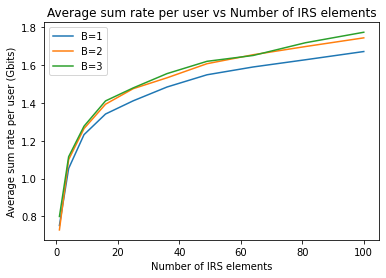

In [299]:
RATE_THRESHOLD = 1.5e9
irs_rows = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Quantization_bit = [1, 2, 3]

Average_Sum_Rate_per_user = np.zeros((3, 10), dtype=float)

# Defining the quantized theta set
for B in Quantization_bit:
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    #print('Quantized_theta_set: ',"\n", (quantized_theta_set))

    for no_irs_ele in irs_rows:

        nIRSrow = no_irs_ele    # Number of rows in the IRS
        nIRScol = no_irs_ele    # Number of columns in the IRS
        Ns = nIRSrow*nIRScol    # Total Number of reflecting elements in the IRS

        Average_rates = np.zeros((1, No_of_Users), dtype=float)
        Avera_Outage_Probability = 0.0

        NUM_SIMULATIONS = 100
        # Perform simulations
        for i in range(NUM_SIMULATIONS):

            ############################# Channels Generation ####################################
            DirectLinkS1 = np.zeros((Nt, IRS1_Associated_Users.shape[0]), dtype=complex)
            DirectLinkS2 = np.zeros((Nt, IRS2_Associated_Users.shape[0]), dtype=complex)
            IRS1UserLink = np.zeros((Ns, IRS1_Associated_Users.shape[0]), dtype=complex)
            IRS2UserLink = np.zeros((Ns, IRS2_Associated_Users.shape[0]), dtype=complex)
            BSIRS1Link = np.zeros((Nt, Ns), dtype=complex)
            BSIRS2Link = np.zeros((Nt, Ns), dtype=complex)
            
            # Generate the Rayleigh Channel (Direct_LinkS1) from Each Base Station antenna to the each User (h_dk)
            for antenna in range(Nt):
                for user in range(IRS1_Associated_Users.shape[0]):
                    x = generate_rayleigh_fading_channel(1, FADING_STD_MEAN, FADING_STD_DEV)
                    DirectLinkS1[antenna, user] = x[0]

            # Generate the Rayleigh Channel (Direct_LinkS2) from Each Base Station antenna to the each User (h_dk)
            for antenna in range(Nt):
                for user in range(IRS2_Associated_Users.shape[0]):
                    x = generate_rayleigh_fading_channel(1, FADING_STD_MEAN, FADING_STD_DEV)
                    DirectLinkS2[antenna, user] = x[0]
            
            DirectLinkS1 = np.array(DirectLinkS1)
            DirectLinkS2 = np.array(DirectLinkS2)

            # Generate the Nakagami Channel from each IRS1 element to each user(IRS1UserLink)
            for element in range(Ns):
                for user in range(IRS1_Associated_Users.shape[0]):
                    y1 = (generate_nakagami_samples(m, omega, 1))
                    IRS1UserLink[element, user] = y1[0]

            IRS1UserLink = np.array(IRS1UserLink)

            # Generate the Nakagami Channel from each IRS2 element to each user(h_rk)
            for element in range(Ns):
                for user in range(IRS2_Associated_Users.shape[0]):
                    y2 = (generate_nakagami_samples(m, omega, 1))
                    IRS2UserLink[element, user] = y2[0]

            IRS2UserLink = np.array(IRS2UserLink)

            # Generate the Nakagami Channel from each antenna to each user(h_rk)
            for antnn in range(Nt):
                for element in range(Ns):
                    z1 = (generate_nakagami_samples(m, omega, 1))
                    BSIRS1Link[antnn, element] = z1[0]

            BSIRS1Link = np.array(BSIRS1Link)

            # Generate the Nakagami Channel from each IRS1 element to each user(h_rk)
            for antnn in range(Nt):
                for element in range(Ns):
                    z2 = (generate_nakagami_samples(m, omega, 1))
                    BSIRS2Link[antnn, element] = z2[0]

            BSIRS2Link = np.array(BSIRS2Link)

            
            # print('Direct Link: \n', DirectLink)
            # print('IRS1 User Link: \n', IRS1UserLink)
            # print('IRS2 User Link: \n', IRS2UserLink)
            # print('BS IRS1 Link: \n', BSIRS1Link)
            # print('BS IRS2 Link: \n', BSIRS2Link)


            ############################# Theta Matrix Calculation ####################################
            IRS1Theta_Matrix = np.zeros((Nt, Ns, IRS1_Associated_Users.shape[0]), dtype=complex)
            IRS2Theta_Matrix = np.zeros((Nt, Ns, IRS2_Associated_Users.shape[0]), dtype=complex)

            for antenna in range(Nt):
                for element in range(Ns):
                    for user in range(IRS1_Associated_Users.shape[0]):
                        # theta_n1 =  np.angle(DirectLink[antenna,user]) - (np.angle(BSIRS1Link[antenna,element]) + np.angle(IRS1UserLink[element,user]))
                        theta_n1 = - np.angle(BSIRS1Link[antenna,element]) - np.angle(IRS1UserLink[element,user])

                        # Adjust theta_n to lie within the range (-π, π)
                        theta_n1 = (theta_n1 + np.pi) % (2 * np.pi) - np.pi
                        
                        # Find the nearest quantized theta value
                        nearest_quantized_theta1 = quantized_theta_set[np.argmin(np.abs(theta_n1 - quantized_theta_set))]

                        IRS1Theta_Matrix[antenna,element,user] = nearest_quantized_theta1

                    for user in range(IRS2_Associated_Users.shape[0]):
                        # theta_n2 =  np.angle(DirectLink[antenna,user]) - (np.angle(BSIRS2Link[antenna,element]) + np.angle(IRS2UserLink[element,user]))
                        theta_n2 = - np.angle(BSIRS2Link[antenna,element]) - np.angle(IRS2UserLink[element,user])

                        # Adjust theta_n to lie within the range (-π, π)
                        theta_n2 = (theta_n2 + np.pi) % (2 * np.pi) - np.pi
                        
                        # Find the nearest quantized theta value
                        nearest_quantized_theta2 = quantized_theta_set[np.argmin(np.abs(theta_n2 - quantized_theta_set))]

                        IRS2Theta_Matrix[antenna,element,user] = nearest_quantized_theta2

            IRS1Theta_Matrix = (1 * np.exp(1j * IRS1Theta_Matrix))
            IRS2Theta_Matrix = (1 * np.exp(1j * IRS2Theta_Matrix))

            # print('IRS1Theta_Matrix \n', IRS1Theta_Matrix)
            # print('IRS1Theta_Matrix shape \n', IRS2Theta_Matrix.shape)


            ############################# Result Matrix Calculation ####################################
            IRS1Result_Matrix = np.zeros((Nt, IRS1_Associated_Users.shape[0]), dtype=complex)
            IRS2Result_Matrix = np.zeros((Nt, IRS2_Associated_Users.shape[0]), dtype=complex)

            for antenna in range(Nt):
                for user in range(IRS1_Associated_Users.shape[0]):
                    #extrcating the theta array
                    theta_row1 = IRS1Theta_Matrix[antenna,:,user]
                    theta_row1 = np.reshape(theta_row1,(1,no_irs_ele**2))
                    theta_row1 = np.array(theta_row1)

                    # print('theta_row1\n',theta_row1)
                    # print('theta_row1 shape\n',theta_row1.shape)
                    
                    #converting the theta array into diagonal matrix
                    diag_thetarow1 = np.diag(theta_row1[0])
                    # print('diag_thetarow1\n',diag_thetarow1)
                    # print('diag_thetarow1 shape\n',diag_thetarow1.shape)

                    #extrcating the BSIRS array
                    BSIRS1Link_row = BSIRS1Link[antenna,:]
                    BSIRS1Link_row = np.reshape(BSIRS1Link_row,(1,no_irs_ele**2))
                    BSIRS1Link_row = np.array(BSIRS1Link_row)
                    # print('BS to IRS\n',BSIRS1Link_row)
                    # print('BS to IRS shape\n',BSIRS1Link_row.shape)

                    #exracting the IRS(1,2)UserLink array
                    IRS1UserLink_row = IRS1UserLink[:,user]
                    IRS1UserLink_row = np.reshape(IRS1UserLink_row,(no_irs_ele**2,1))
                    IRS1UserLink_row = np.array(IRS1UserLink_row)
                    # print('IRS to User\n',IRS1UserLink_row)
                    # print('IRS to User shape\n',IRS1UserLink_row.shape)

                    # Calculating the result matrix
                    inter1 = np.matmul(BSIRS1Link_row, diag_thetarow1)
                    final1 = np.matmul(inter1, IRS1UserLink_row)
                    IRS1Result_Matrix[antenna,user] = final1[0,0]


                for user in range(IRS2_Associated_Users.shape[0]):
                    #extrcating the theta array
                    theta_row2 = IRS2Theta_Matrix[antenna,:,user]
                    theta_row2 = np.reshape(theta_row2,(1,no_irs_ele**2))
                    theta_row2 = np.array(theta_row2)
                    
                    #converting the theta array into diagonal matrix
                    diag_thetarow2 = np.diag(theta_row2[0])

                    #extrcating the BSIRS array
                    BSIRS2Link_row = BSIRS2Link[antenna,:]
                    BSIRS2Link_row = np.reshape(BSIRS2Link_row,(1,no_irs_ele**2))
                    BSIRS2Link_row = np.array(BSIRS2Link_row)

                    #exracting the IRS(1,2)UserLink array
                    IRS2UserLink_row = IRS2UserLink[:,user]
                    IRS2UserLink_row = np.reshape(IRS2UserLink_row,(no_irs_ele**2,1))
                    IRS2UserLink_row = np.array(IRS2UserLink_row)

                    # Calculating the result matrix
                    inter2 = np.matmul(BSIRS2Link_row, diag_thetarow2)
                    final2 = np.matmul(inter2, IRS2UserLink_row)
                    # print('final2\n',final2)
                    # print('final2 shape\n',final2.shape)
                    IRS2Result_Matrix[antenna,user] = final2[0,0]

            IRS1Result_Matrix = np.array(IRS1Result_Matrix)
            IRS2Result_Matrix = np.array(IRS2Result_Matrix)
            
            # print('IRS1Result_Matrix: ',"\n", (IRS1Result_Matrix))
            # print(np.shape(IRS1Result_Matrix))
            # print('IRS2Result_Matrix: ',"\n", (IRS2Result_Matrix))
            # print(np.shape(IRS2Result_Matrix))

            ############################# LinkBudget Calculation ####################################

            link_inter1= np.zeros((1, IRS1_Associated_Users.shape[0]), dtype=complex)
            link_inter2= np.zeros((1, IRS2_Associated_Users.shape[0]), dtype=complex)

            for user in range(IRS1_Associated_Users.shape[0]):
                link_inter1[0,user] = (TRANSMIT_POWER_WATTS)**0.5 * (((DirectLinkS1[0][user]*0)/(np.sqrt((dTU_S1[0][user])**ZETA))) + ((IRS1Result_Matrix[0][user])/(np.sqrt((dS1U_S1[0][user])**BETA * (dTS1[0][user])**PATH_LOSS_EXPONENT))))

            for user in range(IRS2_Associated_Users.shape[0]):
                link_inter2[0,user] = (TRANSMIT_POWER_WATTS)**0.5 * (((DirectLinkS2[0][user]*0)/(np.sqrt((dTU_S2[0][user])**ZETA))) + ((IRS2Result_Matrix[0][user])/(np.sqrt((dS2U_S2[0][user])**BETA * (dTS2[0][user])**PATH_LOSS_EXPONENT))))

            # print('Link Interference1: ',"\n", (link_inter1))
            # print('Link Interference2: ',"\n", (link_inter2))

            link_inter = np.concatenate((link_inter1, link_inter2), axis=1)

            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,user_positions.shape[0])

            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30 
            link_budget = link_budget.reshape(1,user_positions.shape[0])

            #print('Link Budget: ',"\n", (link_budget))
            #print(np.shape(link_budget))

            # Calculate SNR
            SNR_matrix = []
            for i in range(user_positions.shape[0]):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)

            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,user_positions.shape[0])

            #print('SNR_matrix: ',"\n", (SNR_matrix))

            # Calculate rate 
            rate_matrix = (BW) * compute_rate((SNR_matrix))
            #rate_matrix = compute_rate((SNR_matrix))
            Average_rates = Average_rates + rate_matrix
            #print('rate_matrix: ',"\n", (rate_matrix))

            # Compute the outage probability
            outage_probability = 0.0
            outage_probability = compute_outage_probability(user_positions.shape[0], rate_matrix.flatten(), RATE_THRESHOLD)
            Avera_Outage_Probability = Avera_Outage_Probability + outage_probability
            #print('Outage Probability: ',"\n", (outage_probability))

            # print('Direct Link: \n', DirectLink)
            # print('IRS1 User Link: \n', IRS1UserLink)
            # print('IRS2 User Link: \n', IRS2UserLink)
            # print('BS IRS1 Link: \n', BSIRS1Link)
            # print('BS IRS2 Link: \n', BSIRS2Link)

        # print('Average Sum Rate per user: (in Gbits/Hz)',"\n", (np.sum(Average_rates)/(user_positions.shape[0]*NUM_SIMULATIONS*1e9)))
        # print('Average_Outage_Probability: ',"\n", (Avera_Outage_Probability/NUM_SIMULATIONS))

        Average_Sum_Rate_per_user[B-1][no_irs_ele-1] = np.sum(Average_rates)/(user_positions.shape[0]*NUM_SIMULATIONS*1e9)

print('Average_Sum_Rate_per_user: ',"\n", (Average_Sum_Rate_per_user))
# Plot the graphs of avergae sum rate per user vs number of IRS elements for different quantization bits
Qbit1 = Average_Sum_Rate_per_user[0,:]
Qbit2 = Average_Sum_Rate_per_user[1,:]
Qbit3 = Average_Sum_Rate_per_user[2,:]
irs_rows_plots = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
plt.plot(irs_rows_plots, Qbit1, label='B=1')
plt.plot(irs_rows_plots, Qbit2, label='B=2')
plt.plot(irs_rows_plots, Qbit3, label='B=3')
plt.xlabel('Number of IRS elements')
plt.ylabel('Average sum rate per user (Gbits)')
plt.title('Average sum rate per user vs Number of IRS elements')
plt.legend()
